# Advanced Tutorial 4 : build a Spectral Deferred Correction solver based on generic time-integrators

📜 _Previous advanced tutorial on [SDC](./13_nonLinearSDC.ipynb) focused on its implementation for non-linear ODEs using_ $Q_\Delta$_-coefficients._
_But we can also define a SDC sweep **without**_ $Q_\Delta$ _**coefficients**, and extend this idea to many other time-integration approaches._

> ©️ Credits to [Martin Schreiber](https://www.martin-schreiber.info) for the original idea behind this 
> [here](https://gitlab.inria.fr/sweet/sweet/-/blob/main/doc/time_integration/spectral_deferred_correction_methods/spectral_deferred_corrections_with_less_pain_ver_2024_01_19.pdf?ref_type=heads).


$\phi$**-based time-integrator** : 

Considering a sequence of nodes 
$\{\tau_1, ..., \tau_M\}$ discretizing one time-step 
$\{t_0, t_0+\Delta{t}\}$ into
$\{t_1, \dots, t_M\} = \{t_0+\Delta{t}\tau_1, \dots, t_0 + \Delta{t}\tau_M\}$.
We can write one time-integrator computing the step solution through all node as a 
$\phi$ function such that :

$$
u_{m} - \phi(u_0, u_1, ..., u_{m}) = u_0
$$

This allows to represent any other time-integrator, 
without the restriction writing it in a $Q$-coefficient framework.
In particular, if we look at the Picard form of an ODE written 
at a given time node :

$$
u_m = u_0 + \int_{t_0}^{t_m} f(u(s), s) ds
$$

the $\phi$ function simply corresponds to a given discretization
of the integral into the time nodes
$\{t_1, \dots, t_m\}$, with no dependency to the next time nodes.

**Continuous Spectral Deferred Correction**

To retrieve the original SDC formulation of SDC, we define the error
$e^{k}(t) = u(t) - u^{k}(t)$
and put it in the Picard equation above to get :

$$
\begin{align}
e^{k}(t) + u^{k}(t) 
    &= e^{k}(t_0) + u^{k}(t_0) + \int_{t_0}^t f\left(e^{k}(s) - u^{k}(s), s\right) ds \\
    &= u_0 + \int_{t_0}^t f\left(e^{k}(s) + u^{k}(s), s\right) ds.
\end{align}
$$

Noting 
$u^{k+1}(t) := e^{k}(t) + u^{k}(t)$
and adding the difference of the two same integral terms with $u^{k}$ we get :

$$
\begin{align}
u^{k+1}(t) 
    =&~ u_0 + \int_{t_0}^t f\left(u^{k+1}(s), s\right) ds \\
    &- \int_{t_0}^t f\left(u^{k}(s), s\right) ds + \int_{t_0}^t f\left(u^{k}(s), s\right) ds \\
    =&~ u_0 + \int_{t_0}^t f\left(u^{k+1}(s), s\right) ds - \int_{t_0}^t f\left(u^{k}(s), s\right) ds \\
    &+ \int_{t_0}^t f\left(u^{k}(s), s\right) ds
\end{align}
$$

$\phi$**-based Spectral Deferred Correction** : 

We write the continuous SDC equation at a given time node $t_{m+1}$,
use a given $\phi$ time integrator to replace the two integrals, 
and write the last integral using a quadrature rule **on all time nodes** :

$$
u^{k+1}_{m+1} = u_0 + \phi(u_0, u^{k+1}_1, ..., u^{k+1}_{m+1}) - \phi(u_0, u^{k}_1, ..., u^{k}_{m+1})
    + \Delta{t}\sum_{j=0}^{M} \omega_j f(u^k_j, t_j)
$$

or in final form :

$$
u^{k+1}_{m+1} - \phi(u_0, u^{k+1}_1, ..., u^{k+1}_{m+1})
    = u_0 + \Delta{t}\sum_{j=0}^{M} \omega_j f(u^k_j, t_j) - \phi(u_0, u^{k}_1, ..., u^{k}_{m+1})
$$

✨ And there it is : no need of any $Q_\Delta$ coefficient !
We just need to use the definition of a time-integrator that allows to 

- evaluate $\phi(u_0, u_1, ..., u_{m+1})$ for any sequences of node solutions up to the $(m+1)^{th}$ one,
- solve $u - \phi(u_0, u_1, ..., u_{m}, u) = rhs$ for any $rhs$ vector.

## Prerequisite

We use the same as for the [previous tutorial](./12_nonLinearRK.ipynb) :

In [1]:
import numpy as np
from scipy.optimize import fsolve

u0 = np.array([5, -5, 20])
sigma, rho0, beta, epsilon = 10, 28, 8/3, 5


def f(u, t):
    x, y, z = u
    rho = rho0 + epsilon*np.sin(t)
    return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])


def fSolve(a, t, rhs, uInit):

    def res(u):
        return u - a*f(u, t) - rhs

    return fsolve(res, uInit)

In addition, we define our underlying collocation problem :

In [3]:
from qmat.qcoeff.collocation import Collocation

qGen = Collocation(nNodes=4, nodeType="LEGENDRE", quadType="RADAU-RIGHT")
nodes, weights, Q = qGen.genCoeffs()

## Implementation

Consider a Backward Euler step between each node, and let us write it in $\phi$ formulation.
Defining $\Delta{\tau}_m = t_{m}-t_{m-1}$, we have for each node

$$
\begin{align}
u_1 - \Delta{\tau}_1 f(u_1, t_1) &= u_0 \\
u_2 - \Delta{\tau}_2 f(u_2, t_2) &= u_1 \\
\dots& \\
u_M - \Delta{\tau}_M f(u_M, t_M) &= u_{M-1}
\end{align}
$$

By substitution we can rearrange those into :

$$
\begin{align}
u_1 - \Delta{\tau}_1 f(u_1, t_1) &= u_0 \\
u_2 - \Delta{\tau}_2 f(u_2, t_2) - \Delta{\tau}_1 f(u_1, t_1) &= u_0 \\
\dots& \\
u_M - \Delta{\tau}_M f(u_M, t_M) - \dots - \Delta{\tau}_1 f(u_1, t_1) &= u_0
\end{align}
$$

so we can identify the $\phi$ function for Backward Euler :

$$
\phi(u_0, u_1, ..., u_{m+1}) = \Delta{\tau}_{m+1} f(u_{m+1}, t_{m+1}) + \dots + \Delta{\tau}_1 f(u_1, t_1)
$$

In [ ]:
def phi(uNodes, t0, dt):
    tau = [t0] + (t0 + dt*nodes).tolist()
    out = 0
    for i, u in enumerate(uNodes[1:]):
        dTau = tau[i+1] - tau[i]
        out = out + dTau*f(u, tau[i+1])
    return out

Then we can define a function to solve $u - \phi(u_0, u_1, ..., u_{m}, u) = rhs$ for any $rhs$ vector :

In [10]:
from scipy.optimize import fsolve

def phiSolve(uNodes, rhs, uInit, t0, dt):
    tau = [t0] + (t0 + dt*nodes).tolist()

    for i, u in enumerate(uNodes[1:]):
        dTau = tau[i+1] - tau[i]
        rhs = rhs + dTau*f(u, tau[i+1])

    m = len(uNodes) - 1
    dTau = tau[m+1] - tau[m]
    def res(u):
        return u - dTau*f(u, tau[m+1]) - rhs

    return fsolve(res, uInit)

And now, we just need to implement the $\phi$-based SDC formula as defined before :

In [16]:
nSweeps = 4
uNodes = np.zeros((nSweeps+1, nodes.size, u0.size))

tEnd = 10
nSteps = 1000

uNum = np.zeros((nSteps+1, u0.size))
times = np.linspace(0, tEnd, nSteps+1)


uNum[0] = u0
for i in range(nSteps):
    dt = times[i+1] - times[i]
    tNodes = times[i] + dt*nodes
    u0 = uNum[i]

    # Initialize k=0 with u0
    uNodes[0][:] = u0

    # Iteration loop
    for k in range(nSweeps):

        # Loop on nodes
        for m in range(len(nodes)):
            rhs = uNum[i].copy()

            # Quadrature terms
            for j in range(len(nodes)):
                rhs += dt*Q[m, j]*f(uNodes[k, j], tNodes[j])

            # Phi correction term
            rhs -= phi([u0, *uNodes[k, :m+1]], times[i], dt)

            # Phi solve
            uNodes[k+1, m] = phiSolve([u0, *uNodes[k+1, :m]], rhs, uNodes[k, m], times[i], dt)

    # Step update
    uNum[i+1] = u0
    for m in range(len(nodes)):
        uNum[i+1] += dt*weights[m]*f(uNodes[-1, m], tNodes[m])


And that's it 🥳 ! We solved our non-linear time-dependent ODE on the given time frame using 4 SDC sweeps, 
without using any $Q_\Delta$ coefficients  ...

As before, we can plot the solution with respect to time : 

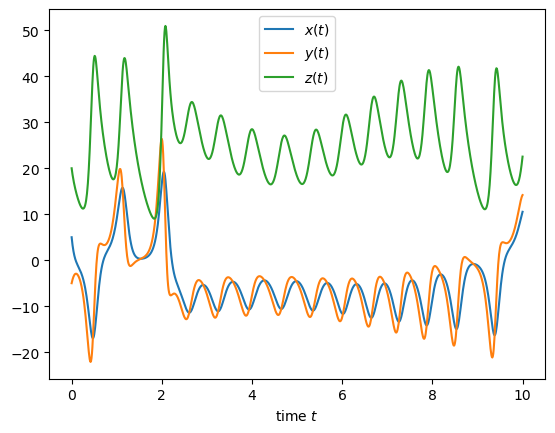

In [12]:
import matplotlib.pyplot as plt

plt.plot(times, uNum[:, 0], label="$x(t)$")
plt.plot(times, uNum[:, 1], label="$y(t)$")
plt.plot(times, uNum[:, 2], label="$z(t)$")
plt.legend(); plt.xlabel("time $t$");

> 💡 Note that we retrieve exactly the same solution as the first application example given in [previous tutorial](./13_nonLinearSDC.ipynb).

And as before, we can implement a function to reuse it with different time resolution, blablabla ...

## Using the internal $\phi$-SDC solver

An optimized implementation of this $\phi$-SDC approach is implemented in the `qmat.solvers.generic.PhiSolver`
class, along with some classical time integrator written in $\phi$ formulation.
As for the `CoeffSolver` used in previous tutorials, they use a `DiffOp` class to evaluate $f(u,t)$.

Looking at the non-perturbed Lorenz example problem (again), we can solve it with $\phi$-SDC using those few lines :

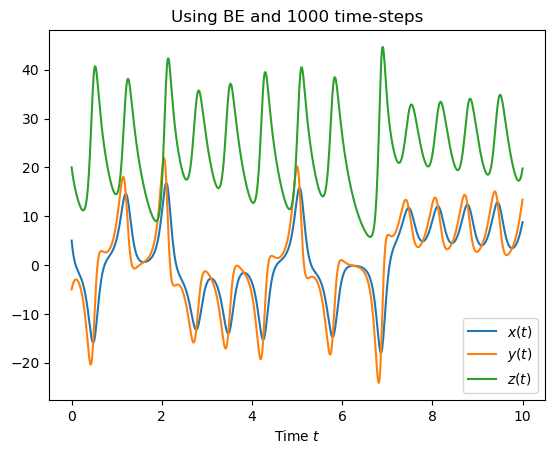

In [17]:
from qmat.qcoeff.collocation import Collocation
from qmat.solvers.generic.integrators import BackwardEuler
from qmat.solvers.generic.diffops import Lorenz

scheme = "BE"
nSteps = 1000
nSweeps = 4

qGen = Collocation(nNodes=4, nodeType="LEGENDRE", quadType="RADAU-RIGHT")
nodes, weights, Q = qGen.genCoeffs()

solver = BackwardEuler(Lorenz(), nodes, tEnd=10, nSteps=nSteps)
uNum = solver.solveSDC(nSweeps, Q, weights)

plt.plot(solver.times, uNum[:, 0], label="$x(t)$")
plt.plot(solver.times, uNum[:, 1], label="$y(t)$")
plt.plot(solver.times, uNum[:, 2], label="$z(t)$")
plt.legend(); plt.xlabel("Time $t$"); plt.title(f"Using {scheme} and {nSteps} time-steps");

📣 Additional $\phi$ integrators can be implemented, using the following template :

In [ ]:
from qmat.solvers.generic import PhiSolver

class Phidlidoo(PhiSolver):

    def evalPhi(self, uVals, fEvals, out, t0=0):
        """
        Parameters
        ----------
        uVals : list[np.ndarray] of size :math:`m+2`
            The :math:`m+1` time-node solutions + the initial solution :math:`u_0`.
        fEvals : list[np.ndarray] of size :math:`m+1` or :math:`m+1`
            The :math:`f(u,t)` evaluations at each time nodes (+ initial solution),
            up to time-node :math:`m`.
            It can eventually contain a pre-computed :math:`f_{m+1}`
            to spare one :math:`f(u,t)` evaluation.
        out : np.ndarray
            Array used to store the evaluation.
        t0 : float, optional
            Initial step time. The default is 0.
        """
        out[:] = ... # your implementation

For more details, see the [short developer guide](../devdoc/addPhiIntegrator.md) on this aspect ...

## Fun fact

Back to the $\phi$-SDC formula

$$
u^{k+1}_{m+1} - \phi(u_0, u^{k+1}_1, ..., u^{k+1}_{m+1})
    = u_0 + \Delta{t}\sum_{j=0}^{M} \omega_j f(u^k_j, t_j) - \phi(u_0, u^{k}_1, ..., u^{k}_{m+1})
$$

we can rearrange it into :

$$
u^{k+1}_{m+1}
    = u_0 + \Delta{t}\sum_{j=0}^{M} \omega_j f(u^k_j, t_j) + u_0 + \phi(u_0, u^{k+1}_1, ..., u^{k+1}_{m+1}) - u_0 - \phi(u_0, u^{k}_1, ..., u^{k}_{m+1}).
$$

Now, looking back at the definition of those $\phi$ integrators,
we can actually write each part on the right hand side as a dedicated time-integrator.
So if we note :

- $G[t_0 \rightarrow t_{m+1}](u^{k+1}) := u_0 + \phi(u_0, u^{k+1}_1, ..., u^{k+1}_{m+1})$,
- $G[t_0 \rightarrow t_{m+1}](u^{k}) := u_0 + \phi(u_0, u^{k}_1, ..., u^{k+1}_{m})$,
- $F[t_0 \rightarrow t_{m+1}](u^{k}) := u_0 + \Delta{t}\sum_{j=0}^{M} \omega_j f(u^k_j, t_j)$,

this produces the following formula :

$$
u^{k+1}_{m+1} = F[t_0 \rightarrow t_{m+1}](u^{k}) + G[t_0 \rightarrow t_{m+1}](u^{k+1}) - G[t_0 \rightarrow t_{m+1}](u^{k}).
$$

This resemble furiously to a [Parareal](https://en.wikipedia.org/wiki/Parareal) formula (what a chock 😮).
However, there is some particular difference in the fact that the $F$ integrator depends on point forward in time,
which is not the case in Parareal.
